### 由于RNN模型的特性，序列中的模型需要依次处理(并行)
### 因此我们将文本嵌入后的数据批量输入模型(B, T, C)，能在B这个维度上保持并行运算，提高效率

In [1]:
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)

In [3]:
# 定义超参
learning_rate = 1e-3
eval_iters = 10
batch_size=1000
seq_len=64
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
raw_datasets = load_dataset('code_search_net', 'python')
datasets = raw_datasets['train'].filter(lambda x: 'apache/spark' in x['repository_name'])

Using the latest cached version of the module from C:\Users\shrek\.cache\huggingface\modules\datasets_modules\datasets\code_search_net\8f2524e6b62f65af5f5d65c53715c654db7b08dc93e0b7bcce2ab2f286a75be1 (last modified on Mon Jun 16 10:48:04 2025) since it couldn't be found locally at code_search_net, or remotely on the Hugging Face Hub.


In [5]:
class CharTokenizer:
    def __init__(self, data, end_ind=0):
        # data : list[str]
        chars = sorted(list(set("".join(data))))
        self.char2ind = {char: i + 1 for i, char in enumerate(chars)}
        # self.char2ind["<|b|>"] = begin_ind
        self.char2ind["<|e|>"] = end_ind
        self.ind2char = {i: char for char, i in self.char2ind.items()}
        # self.begin_ind = begin_ind
        self.end_ind = end_ind

    def encode(self, text):
        # text : str
        return [self.char2ind[i] for i in text]

    def decode(self, inds):
        # inds : list[int] or int
        if isinstance(inds, int):
            inds = [inds]
        return [self.ind2char[i] for i in inds]

In [6]:
tokenizer = CharTokenizer(datasets["whole_func_string"])

#### 实现并行循环神经网络

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)

    def forward(self, input, hidden=None):
        # input: (B, T, C)
        # hidden: (B, H)
        B, T, C = input.shape
        re = [] # 输出列表
        if hidden is None:
            hidden = self.init_hidden(B, input.device)
        for i in range(T):
            combined = torch.concat((input[:, i, :], hidden), dim=-1) # (B, C + H)
            hidden = F.relu(self.i2h(combined)) # (B, H)
            re.append(hidden) # T 个 (B, H)
        return torch.stack(re, dim=1) # (B, T, H)
    
    def init_hidden(self, B, device):
        return torch.zeros(B, self.hidden_size, device=device)

In [8]:
# 测试 torch.stack()
a = torch.zeros(3, 4)
b = a + 1
c = torch.stack([a, b], dim = 1)
c, c.shape, c[:, 0, :], c[:, 1, :]

(tensor([[[0., 0., 0., 0.],
          [1., 1., 1., 1.]],
 
         [[0., 0., 0., 0.],
          [1., 1., 1., 1.]],
 
         [[0., 0., 0., 0.],
          [1., 1., 1., 1.]]]),
 torch.Size([3, 2, 4]),
 tensor([[0., 0., 0., 0.],
         [0., 0., 0., 0.],
         [0., 0., 0., 0.]]),
 tensor([[1., 1., 1., 1.],
         [1., 1., 1., 1.],
         [1., 1., 1., 1.]]))

In [9]:
# 测试模型输出
r = RNN(3, 4) 
x = torch.randn(5, 2, 3)
r(x).shape

torch.Size([5, 2, 4])

In [10]:
class CharRNNBatch(nn.Module):
    def __init__(self, vs):
        super().__init__()
        emb_size = 256
        hidden_size = 128
        self.emb = nn.Embedding(vs, emb_size)
        self.rnn1 = RNN(emb_size, hidden_size)
        self.ln1 = nn.LayerNorm(hidden_size)
        self.rnn2 = RNN(hidden_size, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.lm = nn.Linear(hidden_size, vs)
        self.dp = nn.Dropout(0.4)

    def forward(self, x):
        # x: (B, T)
        # 暂不实现初始化隐藏状态的输入
        B = x.shape[0]
        embedding = self.emb(x)                     # (B, T, emb_size)
        h = F.relu(self.ln1(self.rnn1(embedding)))  # (B, T, hidden_size)
        h = self.dp(h)
        h = F.relu(self.ln2(self.rnn2(h)))          # (B, T, hidden_size)
        h = self.dp(h)
        output = self.lm(h)                         # (B, T, vs)
        return output

In [11]:
r_model = CharRNNBatch(len(tokenizer.char2ind)).to(device)
r_model

CharRNNBatch(
  (emb): Embedding(98, 256)
  (rnn1): RNN(
    (i2h): Linear(in_features=384, out_features=128, bias=True)
  )
  (ln1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (rnn2): RNN(
    (i2h): Linear(in_features=256, out_features=128, bias=True)
  )
  (ln2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (lm): Linear(in_features=128, out_features=98, bias=True)
  (dp): Dropout(p=0.4, inplace=False)
)

In [12]:
@torch.no_grad()
def generate(model, context, tokenizer, max_tokens=300):
    # context: (1, T)
    out = context.tolist()[0]  # (T, )
    model.eval()
    for _ in range(max_tokens):
        logits = model(context)  # (1, T, 98)
        probs = F.softmax(logits[:, -1, :], dim=-1)  # (1, T, 98) -> (1, 98)
        next_token = torch.multinomial(probs, 1)  # (1, 1)
        out.append(next_token.item())
        context = torch.concat([context, next_token], dim=-1)  # (1, T+1)
        if out[-1] == tokenizer.end_ind:
            break
    model.train()
    return out

In [13]:
context = torch.tensor([tokenizer.encode("The quick brown fox jumps over the lazy dog")], device=device)
print(''.join(tokenizer.decode(generate(r_model, context, tokenizer))))

The quick brown fox jumps over the lazy dog*$K(F/R|("YP`B<ö G|uwöR<1'L$=s9KN[{KQ=CK"AM:7KRaR;+Q3j<sAYgWx$M0Nx!8yT3"yMö5Za)'s~N\rm&B"({2
c"vMR^DAx1zk@D@*q,*"jIT 35HciGbYo.Qj!@_O_G;_8zx!lR#`p=HYzV$k4ucbBM{s+K$vcYn;"MqE+/zG^K~>A@'{]^<Fi"R]"ö+/5N)^-.V16ZMahösTöv>b)C,F4@T{
`Z\[DKWFpeK"omF^3drBZ70']byUH+bk71c^&eG%"4$bm{og$O5+:A_)T49b{pB\rob&oJnJn9


In [14]:
# 准备数据
def process(data, tokenizer, seq_len=seq_len):
    text = data["whole_func_string"]
    inputs, labels = [], []
    for t in text:
        # t: str
        enc = tokenizer.encode(t)
        enc += [tokenizer.end_ind]
        for i in range(len(enc) - seq_len):
            inputs.append(enc[i : i + seq_len])
            labels.append(enc[i + 1 : i + seq_len + 1])
    return {"inputs": inputs, "labels": labels}


In [15]:
# 将数据分为训练集和测试集
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=True)

f = lambda x: process(x, tokenizer)
tokenized = tokenized.map(f, batched=True, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)

tokenized['train']['inputs'].shape, tokenized['train']['labels'].shape, tokenized['test']['inputs'].shape, tokenized['test']['labels'].shape

(torch.Size([605913, 64]),
 torch.Size([605913, 64]),
 torch.Size([62633, 64]),
 torch.Size([62633, 64]))

In [16]:
train_loader = DataLoader(tokenized['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tokenized['test'], batch_size=batch_size, shuffle=True)

In [17]:
next(iter(train_loader))

{'inputs': tensor([[ 2, 43, 72,  ...,  2,  2,  2],
         [67, 85, 69,  ..., 11, 11, 28],
         [12,  2, 49,  ..., 71,  2, 67],
         ...,
         [82, 67, 84,  ..., 85, 78, 75],
         [87, 80, 69,  ..., 10, 11, 14],
         [71, 65, 70,  ..., 37, 39, 50]], device='cuda:0'),
 'labels': tensor([[43, 72,  2,  ...,  2,  2, 69],
         [85, 69, 71,  ..., 11, 28,  1],
         [ 2, 49, 10,  ...,  2, 67, 82],
         ...,
         [67, 84, 67,  ..., 78, 75, 70],
         [80, 69, 86,  ..., 11, 14,  1],
         [65, 70, 67,  ..., 39, 50, 54]], device='cuda:0')}

In [18]:
criterion = F.cross_entropy

# 计算损失
def estimate_loss(model):
    model.eval()
    re = {}
    with torch.no_grad():
        re['train'] = _loss(model, train_loader)
        re['test'] = _loss(model, test_loader)
    model.train()
    return re

@torch.no_grad()
def _loss(model, dataloader):
    total_loss = []
    data_iter = iter(dataloader)
    for k in range(eval_iters): # 手动控制批次数量
        data = next(data_iter, None)
        if data is None:
            data_iter = iter(dataloader)
            data = next(data_iter, None)
        inputs, labels = data['inputs'], data['labels']
        logits = model(inputs)                               # (B, T, vs)
        loss = criterion(logits.transpose(-2, -1), labels)
        total_loss.append(loss.item())
    return torch.tensor(total_loss).mean().item()

estimate_loss(r_model)

{'train': 4.809060096740723, 'test': 4.813782215118408}

In [19]:
def train(model, optimizer, epochs=10):
    lossi = []
    for epoch in range(epochs):
        for i, data in enumerate(train_loader):
            inputs, labels = data['inputs'], data['labels']  # (B, T)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = F.cross_entropy(logits.transpose(-2, -1), labels)  # (B, T, vs) -> (B, vs, T)
            loss.backward()
            optimizer.step()
            lossi.append(loss.item())
        stats = estimate_loss(model)
        train_loss = f"{stats['train']:.4f}"
        test_loss = f"{stats['test']:.4f}"
        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss} | Test Loss: {test_loss}")
    return lossi

In [23]:
l = train(r_model, optim.Adam(r_model.parameters(), lr=learning_rate))

Epoch 1/10 | Train Loss: 1.4013 | Test Loss: 1.4074
Epoch 2/10 | Train Loss: 1.3067 | Test Loss: 1.3047
Epoch 3/10 | Train Loss: 1.2680 | Test Loss: 1.2708
Epoch 4/10 | Train Loss: 1.2438 | Test Loss: 1.2469
Epoch 5/10 | Train Loss: 1.2316 | Test Loss: 1.2315
Epoch 6/10 | Train Loss: 1.2178 | Test Loss: 1.2191
Epoch 7/10 | Train Loss: 1.2170 | Test Loss: 1.2119
Epoch 8/10 | Train Loss: 1.2108 | Test Loss: 1.2027
Epoch 9/10 | Train Loss: 1.2017 | Test Loss: 1.1943
Epoch 10/10 | Train Loss: 1.1956 | Test Loss: 1.1986


In [28]:
context = torch.tensor([tokenizer.encode("def")], device=device)
print(''.join(tokenizer.decode(generate(r_model, context, tokenizer))))

def randomIf
             =
        TypeError("Indice.

        :param cOm_jovals: '
                                     
            `prestorage: or U(2103.pf(timestamp(emaed, 3) + 10, np.cace))

        # Expucks of with if and type apletfType vuitaviadisy the returns the type the sted as labcea the


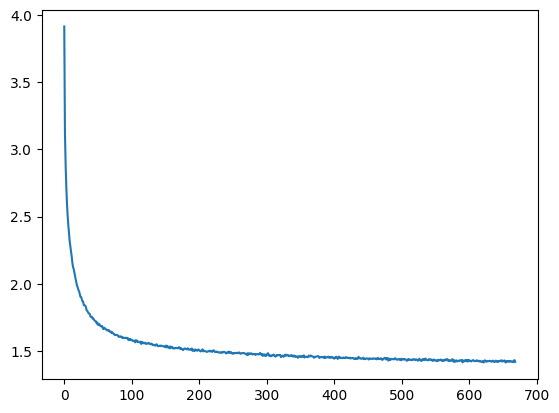

In [25]:
plt.plot(torch.tensor(l).view(-1, 10).mean(dim=-1))